In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim



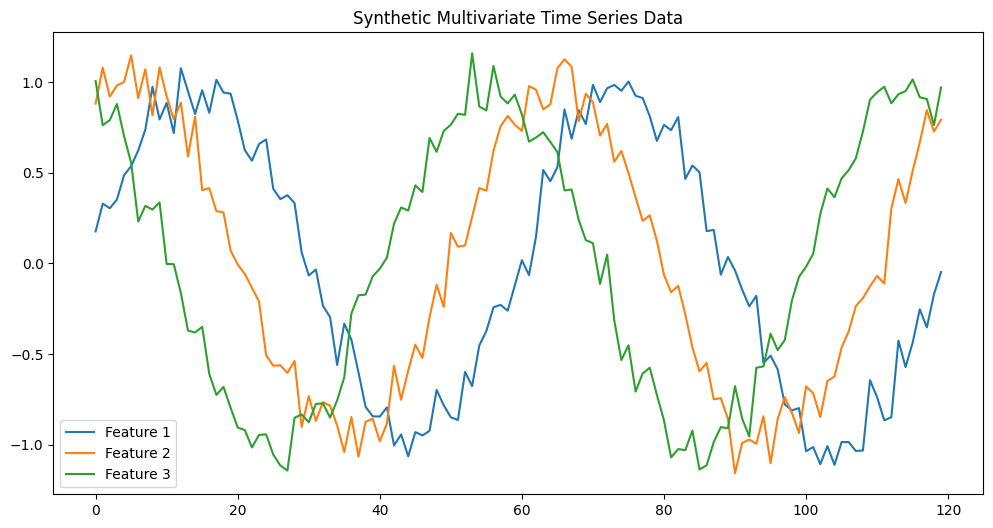

In [9]:

np.random.seed(0)
T = 120  # Total length of the time series
D = 3  # Number of features (dimensions)
time_series = np.array([np.sin(np.linspace(0, 4 * np.pi, T) + i) for i in range(D)]).T + 0.1 * np.random.randn(T, D)

# Plot the time series
plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(time_series[:, d], label=f'Feature {d+1}')
plt.title('Synthetic Multivariate Time Series Data')
plt.legend()
plt.show()


In [10]:
def create_sliding_windows(data, input_window_size, output_window_size):
    X, y = [], []
    for i in range(len(data) - input_window_size - output_window_size + 1):
        X.append(data[i:i + input_window_size])
        y.append(data[i + input_window_size:i + input_window_size + output_window_size])
    return np.array(X), np.array(y)

# Parameters for sliding window
input_window_size = 12
output_window_size = 1

# Create sliding windows
X, y = create_sliding_windows(time_series, input_window_size, output_window_size)
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")


Shape of X: (108, 12, 3), Shape of y: (108, 1, 3)


In [11]:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = D  # Number of features (dimensions)
hidden_size = 50
output_size = D * output_window_size  # Predicting the next time step for each feature
num_layers = 1
num_epochs = 100
learning_rate = 0.001

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(y.shape[0], -1), dtype=torch.float32)

# Create DataLoader
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize model, loss function, and optimizer
model = RNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# Training loop
model.train()
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0164
Epoch [20/100], Loss: 0.0159
Epoch [30/100], Loss: 0.0097
Epoch [40/100], Loss: 0.0096
Epoch [50/100], Loss: 0.0087
Epoch [60/100], Loss: 0.0111
Epoch [70/100], Loss: 0.0082
Epoch [80/100], Loss: 0.0100
Epoch [90/100], Loss: 0.0120
Epoch [100/100], Loss: 0.0078


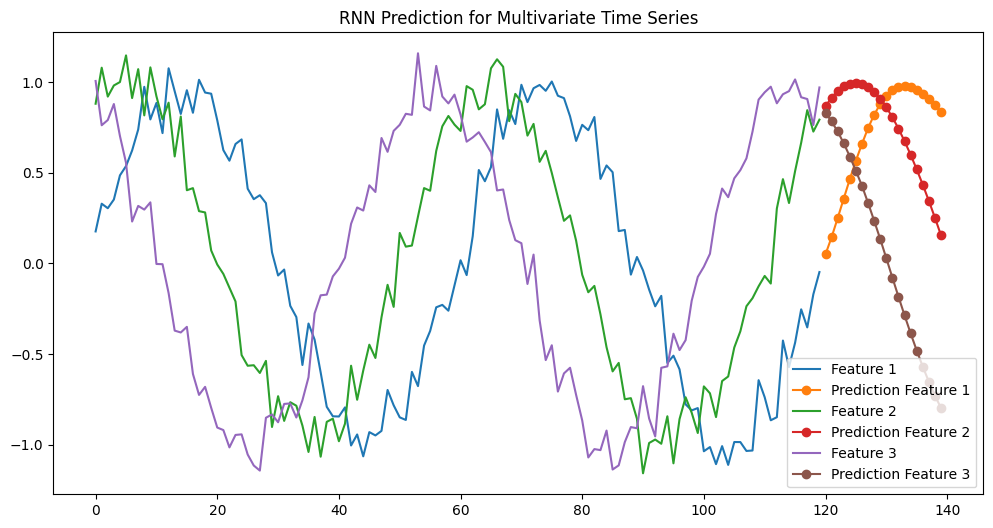

In [13]:
# Switch to evaluation mode
model.eval()

# Make predictions
predictions = []
with torch.no_grad():
    input_seq = time_series[-input_window_size:].copy()
    for _ in range(20):  # Predict 20 data points
        input_tensor = torch.tensor(input_seq[np.newaxis, :, :], dtype=torch.float32)
        prediction = model(input_tensor).numpy().reshape(-1, D)
        predictions.append(prediction)
        input_seq = np.append(input_seq[1:], prediction, axis=0)  # Slide the window

predictions = np.array(predictions).reshape(-1, D)

# Plot the original series and the predictions
plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(time_series[:, d], label=f'Feature {d+1}')
    plt.plot(range(T, T + 20), predictions[:, d], label=f'Prediction Feature {d+1}', marker='o')
plt.legend()
plt.title('RNN Prediction for Multivariate Time Series')
plt.show()
